# SPGR

In [1]:
from multiprocessing import set_start_method
set_start_method('forkserver')

In [2]:
import version_control

Last run on cashlab03-deb at 2015-04-09 09:54:44.929803

Phypno Version: 6374c95883a9a9260ede7e2d451890f11c0e744a

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.1, MarkupSafe==0.23, Pillow==2.8.1, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.3, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==14.05.14, coverage==3.7.1, decorator==3.4.2, docutils==0.12, easydev==0.8.3, ipython==3.1.0, jedi==0.8.1-final0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.6, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.16.0, pandocfilters==1.2.4, pep8==1.6.2, pexpect==3.3, pockets==0.2.4, psutil==2.2.1, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.2, python-igraph==0.7.1-4, pytz==2015.2, pyzmq==14.5.0, requests==2.6.0, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.16.0, scipy==0.15.1, six==1.9.0, snowbal

In [3]:
from spgr import lg

## Co-occurrence of Spindles

### Code

In [4]:
from numpy import arange, max
from spgr.detect_spindles import get_spindles
# from spgr.plot_spindles import hist_overlap
from spgr.plot_spindles import make_hist_overlap
from spgr.constants import GROUP_PATH, HEMI_SUBJ, SPINDLE_OPTIONS

from IPython.display import display

In [5]:
images_dir = GROUP_PATH.joinpath('images').joinpath('spindle_overlap')
if not images_dir.exists():
    images_dir.mkdir()

PLOT_COLOR = 'kw'

In [ ]:
for REREF in ('avg', 15):
    for subj in HEMI_SUBJ:
        v = make_hist_overlap(subj, color=PLOT_COLOR, reref=REREF, nchan=40)
        v.save(str(images_dir.joinpath('hist_{}_{}.png'.format(REREF, subj))))
        display(v)

### Plots of common spindles

In [5]:
from spgr.constants import DATA_OPTIONS, HEMI_SUBJ, SPINDLE_OPTIONS, CHAN_TYPE
from spgr.detect_spindles import get_spindles
from spgr.read_data import get_chan_used_in_analysis
from spgr.spindle_source import get_morph_linear
from spgr.stats_on_spindles import create_spindle_groups, create_spindle_cooccurrence_matrix, mean_spindle_cooccurrence
from spgr.plot_spindles import plot_surf

In [6]:
images_dir = GROUP_PATH.joinpath('images').joinpath('cooccurrence_map')
if not images_dir.exists():
    images_dir.mkdir()

PLOT_COLOR = 'kw'

In [7]:
from numpy import mean, std

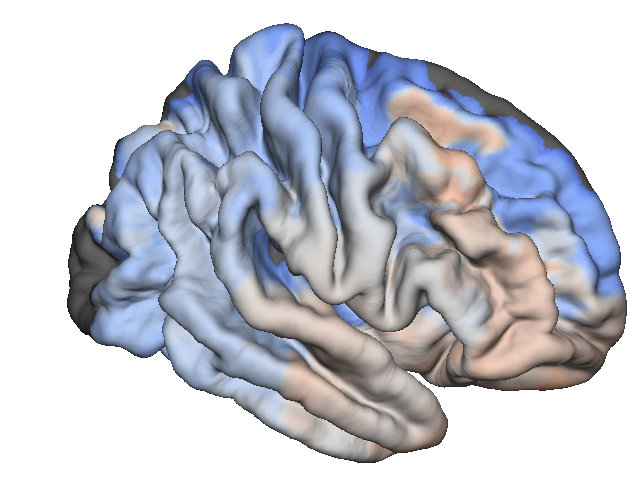

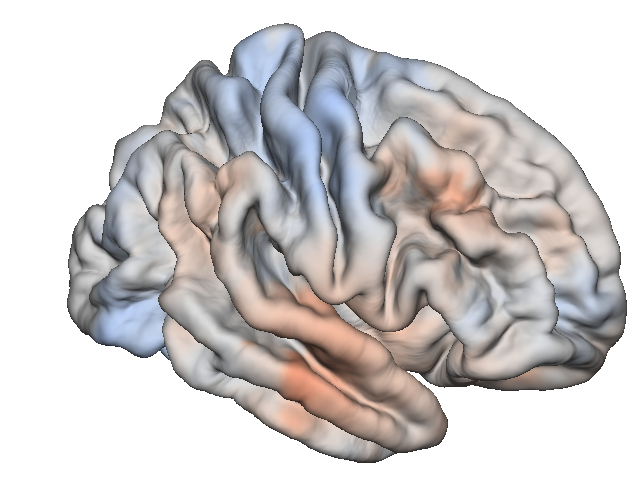

/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:63: RuntimeWarning: invalid value encountered in less
  x.data[0][x.data[0] < threshold[0]] = NaN


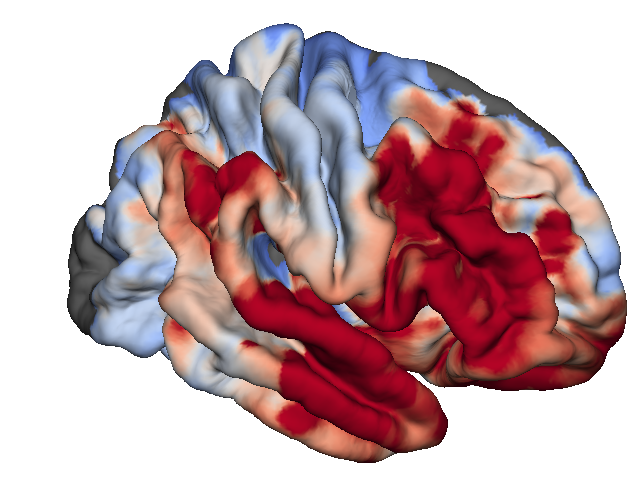

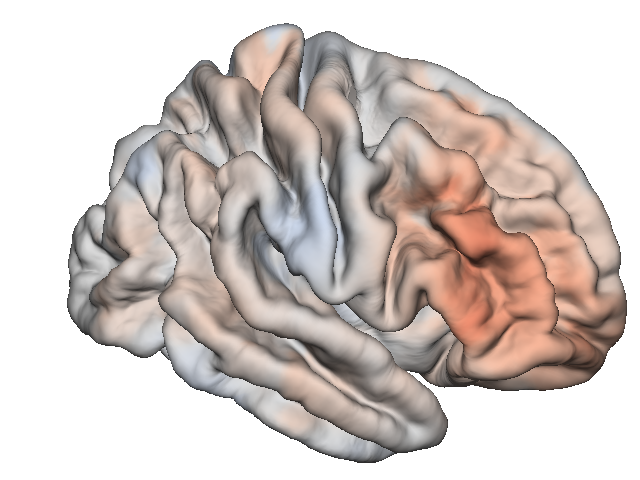

/home/gio/projects/spgr/scripts/spgr/stats_on_spindles.py:150: RuntimeWarning: invalid value encountered in true_divide
  chan_prob_n = chan_prob / diag
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:63: RuntimeWarning: invalid value encountered in less
  x.data[0][x.data[0] < threshold[0]] = NaN


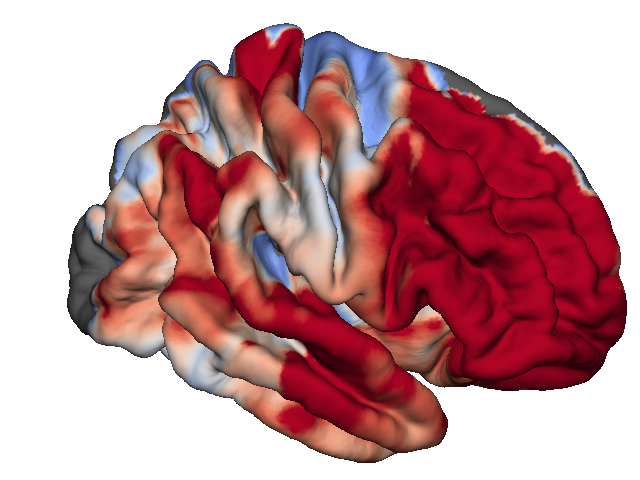

/home/gio/projects/spgr/scripts/spgr/stats_on_spindles.py:150: RuntimeWarning: invalid value encountered in true_divide
  chan_prob_n = chan_prob / diag
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


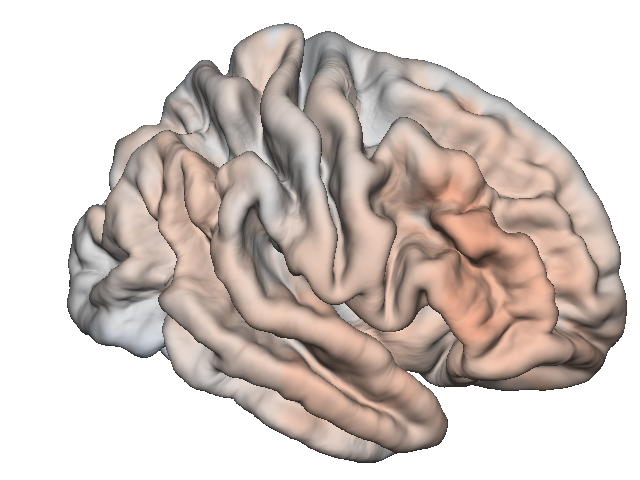

/home/gio/projects/spgr/scripts/spgr/stats_on_spindles.py:150: RuntimeWarning: invalid value encountered in true_divide
  chan_prob_n = chan_prob / diag
/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:63: RuntimeWarning: invalid value encountered in less
  x.data[0][x.data[0] < threshold[0]] = NaN


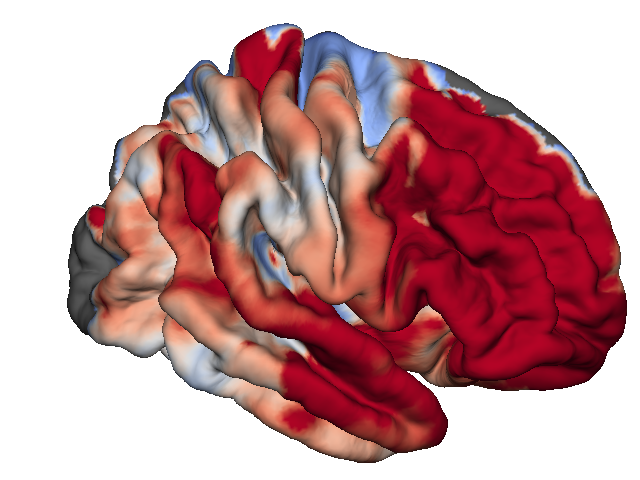

/home/gio/projects/spgr/scripts/spgr/stats_on_spindles.py:150: RuntimeWarning: invalid value encountered in true_divide
  chan_prob_n = chan_prob / diag


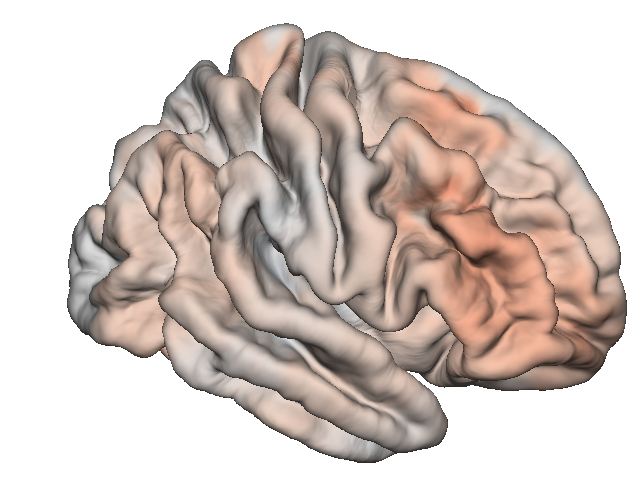

In [9]:
all_values = []

for REREF in ('avg', 15):
    for NORMALIZED_BY in ('source', 'target'):
        for ZSCORE in (False, True):

            for subj in HEMI_SUBJ:
                spindles = get_spindles(subj, reref=REREF, **SPINDLE_OPTIONS)
                spindle_group = create_spindle_groups(spindles)

                chan = get_chan_used_in_analysis(subj, 'sleep', chan_type=CHAN_TYPE, reref=REREF, **DATA_OPTIONS)
                chan_prob = create_spindle_cooccurrence_matrix(chan, spindle_group)
                chan_prob_per_chan = mean_spindle_cooccurrence(chan_prob, normalized_by=NORMALIZED_BY)

                if ZSCORE:
                    chan_prob_per_chan = (chan_prob_per_chan - mean(chan_prob_per_chan)) / std(chan_prob_per_chan)

                morphed = get_morph_linear(subj, chan_prob_per_chan, reref=REREF)

                all_values.append(morphed)

                
            if ZSCORE:
                threshold = None, None
                limits = -1, 1
            else:
                threshold = 0.01, None
                limits = 0, .2
            
            v = plot_surf(all_values, threshold=threshold, limits=limits)
            png_name = 'cooccurrence_map_{}_{}_norm{}.png'.format(NORMALIZED_BY, REREF, ZSCORE)
            v.save(str(images_dir.joinpath(png_name)))
            display(v)

In [ ]:

from pyqtgraph import image

In [ ]:



v = Viz3(color=PLOT_COLOR)
v.add_chan(chan)

In [ ]:
pos = chan.return_xyz((sp[0], sp[1]))

In [ ]:
from pyqtgraph.opengl import GLLinePlotItem

In [ ]:
array(pos_pair_chan)

In [ ]:
sp = chan_group[30]
pos = chan.return_xyz(sp)

v = Viz3()
v.add_chan(chan)

for pos_pair_chan in permutations(pos, 2):
    line = GLLinePlotItem(pos=array(pos_pair_chan), width=4)
    v._widget.addItem(line)

In [ ]:
from itertools import permutations

In [ ]:
from phypno import Data

In [ ]:
from phypno.viz.plot_3d import Viz3
from spgr.read_data import get_data, REC_DIR, FS_PATH
from phypno.attr import Freesurfer
from numpy.linalg import norm

In [ ]:
from spgr.stats_on_spindles import estimate_overlap
from numpy import asarray, sum, where, diff, r_, zeros, diag, mean, NaN, nanmean

In [ ]:
from pyqtgraph import ImageWindow
import pyqtgraph as pg

In [ ]:
from phypno.viz.base import Colormap, Viz
cm = Colormap('coolwarm', limits=(0, 1))

In [ ]:
image(chan_prob_n)

In [ ]:
# GUI
win = pg.GraphicsWindow()
view = win.addViewBox()
view.invertY()
view.setAspectLocked(True)
item = pg.ImageItem(chan_prob)
view.addItem(item)
item.setLookupTable(lut)
item.setLevels([0, 40])

v = Viz()
v._widget = win
v.size = 500, 400
# v.save('/home/gpiantoni/Copy/Presentations/2013_MGH/20150225_UCSD/img/avg/image_cooccurrence.png')
v

In [ ]:
# GUI
win = pg.GraphicsWindow()
view = win.addViewBox()
view.invertY()
view.setAspectLocked(True)
item = pg.ImageItem(chan_prob_n)
view.addItem(item)
item.setLookupTable(lut)
item.setLevels([0, .5])

v = Viz()
v._widget = win
v.size = 500, 400
v.save('/home/gpiantoni/Copy/Presentations/2013_MGH/20150225_UCSD/img/avg/ratio_cooccurrence.png')
v

In [ ]:
from spgr.plot_spindles import plot_surf

In [ ]:
v = plot_surf(all_elec, (0.001, None), (0, .2))
v._widget.setBackgroundColor('w')

Spindles in the prefrontal cortex are mostly likely to co-occur with spindles in other brain areas (Fig. +[spgr_topo_cooccur]).

In [ ]:
if min_distance:
    v.save(join(img_dir, 'sync_spindles_min{}.png'.format(min_distance)))
else:
    v.save(join(img_dir, 'sync_spindles.png'.format(min_distance)))

In [ ]:
from pyqtgraph import GradientWidget

w = GradientWidget(orientation='left')
w.show()

In [ ]:
w.item.setColorMap(cm)